<a href="https://colab.research.google.com/github/ysgrProgramming/hitblow/blob/main/hit_brow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HitBlowの完全解析ツール
解析は以下の手順にて行う。

1. 桁数と使用する数字の種類数を指定し、Analyze_Seedを生成
2. Analyze_Hitblowに生成したAnalyze_Seedを渡し、analyze_xxx_treeでtree_list, paramsを生成。tree_listにはどのように質問するべきかの手順が含まれている。paramsにはtree_listについて最大深さ、ノード数等の簡易的な情報が含まれている。
3. Analyze_Displayにtree_listを渡すことで手順を画像に変換し、視覚的にわかりやすくする。

以上の操作によって、任意の桁数と数字の種類数によるHitBlowの解析を行うことができる。

## 解析道具の構築

### 必要モジュールのインポート、設定

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations, combinations
from graphviz import Digraph
import random
import time

config = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'font.size': 14,
    'axes.linewidth': 1.0,
    'figure.dpi': 144
}
plt.rcParams.update(config)

### Analyze_Seed

解析したいHitBlowの桁数と数字の種類数を入力することで、解析に必要な最適化された関数を作成する。

In [2]:
class Analyze_Seed:
    def __init__(self, digit_size, num_size):
        self.digit_size, self.num_size = digit_size, num_size

        #judge_table作成
        self.judge_table = {}
        
        for pat1 in permutations(range(num_size), digit_size):
            for pat2 in permutations(range(num_size), digit_size):
                self.judge_table[(pat1, pat2)] = self.judge_hb_temp(pat1, pat2)
        
        #judge_pat_list、judge_pat_dict作成
        self.judge_pat_size = (digit_size+1)*(digit_size+2)//2
        self.judge_pat_list = []
        for i in range(digit_size, -1, -1):
            for j in range(digit_size-i, -1, -1):
                self.judge_pat_list.append((i, j))
        self.judge_pat_dict = {v:u for u, v in enumerate(self.judge_pat_list)}
        self.registed_set = set()
        
        self.pat_length = 1
        for i in range(num_size, num_size-digit_size, -1):
            self.pat_length *= i
        self.min_depth_sum_of_length_table = {i: self.min_depth_sum_of_length_temp(i) for i in range(self.pat_length+1)}

        print("initialize completed")
    
    #初期化時のみ使う_temp
    def judge_hb_temp(self, num1, num2):
        hit, blow = 0, 0
        for i in range(self.digit_size):
            for j in range(self.digit_size):
                if num1[i] == num2[j]:
                    if i == j: hit += 1
                    else: blow += 1
                    break
        return hit, blow

    def min_depth_sum_of_length_temp(self, length):
        total = 0
        count = 0
        while length > 0:
            total += length
            length -= (self.judge_pat_size-2)**count
            count += 1
        return total

    #解析ツール
    def judge_hb(self, num1, num2):
        return self.judge_table[(num1, num2)]
    
    def produce_pat_set(self, history_pat_set):
        pat_set = set()
        already_exists = set()
        max_num = -1
        for pat in history_pat_set:
            max_num = max(max_num, max(pat))
        
        for pat in permutations(range(min(self.num_size, max_num+3)), self.digit_size):
            judge_list = []
            
            for num in history_pat_set:
                judge = self.judge_hb(num, pat)
                judge_list.append(judge)
            judge_tuple = tuple(judge_list)
            if judge_tuple not in already_exists:
                pat_set.add(pat)
                already_exists.add(judge_tuple)
            
        if max_num < self.num_size-self.digit_size: pat_set.add(tuple(max_num+i+1 for i in range(self.digit_size)))
        pat_set.difference_update(history_pat_set)
        return pat_set
    
    def distribute_pats(self, key_pat, pat_set):
        sorted_list = [set() for _ in range(self.judge_pat_size)]
        for pat in pat_set:
            hb = self.judge_hb(key_pat, pat)
            index = self.judge_pat_dict[hb]
            sorted_list[index].add(pat)
        return sorted_list

    def min_depth_sum_of_length(self, length):
        return self.min_depth_sum_of_length_table[length]
    
    #木の解析
    def meajure_tree_max_depth(self, tree_list):
        max_depth = 0
        if tree_list[0] != None: max_depth = 1
        for tree in tree_list[1:-1]:
            if type(tree) == tuple: max_depth = max(max_depth, 2)
            elif type(tree) == list: max_depth = max(max_depth, self.meajure_tree_max_depth(tree)+1)
        return max_depth
    
    def meajure_tree_depth_sum(self, tree_list, depth):
        depth_sum = 0
        if tree_list[0] != None: depth_sum += depth
        for tree in tree_list[1:-1]:
            if type(tree) == tuple: depth_sum += depth+1
            elif type(tree) == list: depth_sum += self.meajure_tree_depth_sum(tree, depth+1)
        return depth_sum

    #todo: 不必要にする
    def pats_length(self, question_pat_set, left):
        pat_set = self.produce_pat_set(question_pat_set)
        if left == 1: return len(pat_set)
        
        length = 0
        for pat in pat_set:
            length += self.pats_length(question_pat_set | {pat}, left-1)
    
        return length
    
    def regist(self, pat):
        self.registed_set.add(pat)


#### Analyze_Seedによる最適化
例えばjudge_hbは２つのパターンを比較しhit数とblow数を生成する。
各桁の参照をするとdigit_numの二乗に比例する時間が必要だが、テーブルを作成することで$O(1)$での処理時間に最適化した。

最適化前のjudge_hb_tempと最適化後のjudge_hbの処理時間の違いを以下のコードに示す。

In [3]:
AS = Analyze_Seed(3, 10)
query1 = (0, 1, 2)
query2 = (0, 2, 5)

%timeit AS.judge_hb(query1, query2)
%timeit AS.judge_hb_temp(query1, query2)
hit, blow = AS.judge_hb(query1, query2)

print("-"*20)
print("judge:", query1, query2, "= {0}hit {1}blow".format(hit, blow))

initialize completed
The slowest run took 6.46 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 794 ns per loop
The slowest run took 4.32 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 1.85 µs per loop
--------------------
judge: (0, 1, 2) (0, 2, 5) = 1hit 1blow


### Analyze_Hitblow
Analyze_Seedで作成したSeedを渡し、analyze_xxx_treeを実行することで解析を行う。analyze_xxx_treeには以下の種類がある。

- analyze_fastest_tree(limit=float('inf')): 動作が高速だが、必要最小手順を探索することのみを目的とするため、手順が効率的とは限らない。limitは探索打ち切り手数を表す。

- analyze_earnest_tree(limit=float('inf')): 最も手数の期待値を少なくすることを目的とする。fastestに比べて動作が遅い。limitは探索打ち切りする合計深さを表す。

これらの関数はtree_listとparamsを戻り値とする。tree_listはPractice_Hitblowと合わせて使用し、paramsは解析結果の概観を知らせる。

In [4]:
class Analyze_Hitblow():
    def __init__(self, Seed, print_interval_time=float('inf')):
        self.Seed = Seed

        self.loop_count = 0

        self.print_interval_time = print_interval_time
        self.start_time = 0
        self.previous_time = 0

    #fastest_tree
    def find_fastest_tree(self, key_pat, possible_pat_set, memo, limit=float('inf')):
        self.time_keeper()
        judge_pat_size = self.Seed.judge_pat_size
        regist = self.Seed.regist

        dp_list = self.Seed.distribute_pats(key_pat, possible_pat_set)
        pat_history = memo | {key_pat}
        next_pat_set = self.Seed.produce_pat_set(pat_history)
        max_depth = 0
        tree_list = [None]*judge_pat_size

        if len(dp_list[0]) == 1:
            tree_list[0] = dp_list[0].pop()
            regist(tree_list[0])
        for i in range(1, judge_pat_size):
            dp = dp_list[i]
            min_count = limit

            #limit以下での探索が不可能
            if len(dp) > (judge_pat_size-2)**(limit-2):
                return None, float('inf')

            #dpの長さが2以下の特殊ケース
            if len(dp) == 2:
                a = dp.pop()
                dp.add(a)
                tree, depth = self.find_fastest_tree(a, dp, set())
                max_depth = max(max_depth, depth)
                tree_list[i] = tree
                continue
            elif len(dp) == 1:
                tree_list[i] = dp.pop()
                max_depth = max(max_depth, 1)
                regist(tree_list[i])
                continue
            elif len(dp) == 0:
                continue

            #子となる木を探索
            for pat in next_pat_set:
                tree, depth = self.find_fastest_tree(pat, dp, pat_history, min_count-1)
                if tree != None:
                    min_count = depth
                    tree_list[i] = tree
            if tree_list[i] == None: return None, float('inf')
            max_depth = max(min_count, max_depth)

        tree_list.append(key_pat)
        return tree_list, max_depth+1
    
    def analyze_fastest_tree(self, limit=float('inf')):
        pat = self.Seed.produce_pat_set(set()).pop()

        self.start_time = time.time()
        self.previous_time = self.start_time
        tree_list, depth = self.find_fastest_tree(pat, set(permutations(range(self.Seed.num_size), self.Seed.digit_size)), set(), limit)
        print("analyze completed")

        if tree_list == None: return None, dict()
        else: params = self.generate_params(tree_list)
        print("params setted")

        return tree_list, params

    #earnest_tree
    def find_earnest_tree(self, key_pat, possible_pat_set, memo, limit_depth_sum=float('inf')):
        self.time_keeper()
        judge_pat_size = self.Seed.judge_pat_size
        regist = self.Seed.regist

        dp_list = self.Seed.distribute_pats(key_pat, possible_pat_set)
        #print(dp_list)
        pat_history = memo | {key_pat}
        next_pat_set = self.Seed.produce_pat_set(pat_history)
        depth_sum = len(possible_pat_set)+sum([self.Seed.min_depth_sum_of_length(len(dp)) for dp in dp_list[1:]])
        if depth_sum >= limit_depth_sum: return None, float('inf')
        tree_list = [None]*judge_pat_size
        
        if len(dp_list[0]) == 1: tree_list[0] = dp_list[0].pop()
        for i in range(1, judge_pat_size):
            dp = dp_list[i]
            depth_sum -= self.Seed.min_depth_sum_of_length(len(dp))
            min_depth = limit_depth_sum-depth_sum

            #dpの長さが2以下の特殊ケース
            if len(dp) == 2:
                a = dp.pop()
                dp.add(a)
                tree, tree_depth = self.find_earnest_tree(a, dp, set())
                tree_list[i] = tree
                depth_sum += 3
                continue
            elif len(dp) == 1:
                tree_list[i] = dp.pop()
                depth_sum += 1
                regist(tree_list[i])
                continue
            elif len(dp) == 0: continue

            #子となる木を探索
            for pat in next_pat_set:
                tree, tree_depth = self.find_earnest_tree(pat, dp, pat_history, min_depth)
                if tree != None:
                    #print("○", tree, min_depth, tree_depth)
                    min_depth = tree_depth
                    tree_list[i] = tree
            if tree_list[i] == None: return None, float('inf')
            depth_sum += min_depth

        tree_list.append(key_pat)
        return tree_list, depth_sum
    
    def analyze_earnest_tree(self, limit=float('inf')):
        pat = self.Seed.produce_pat_set(set()).pop()

        self.start_time = time.time()
        self.previous_time = self.start_time
        tree_list, depth_sum = self.find_earnest_tree(pat, set(permutations(range(self.Seed.num_size), self.Seed.digit_size)), set(), limit+1)
        print("analyze completed")

        if tree_list == None: return None, dict()
        else: params = self.generate_params(tree_list)
        print("params setted")

        return tree_list, params

    def time_keeper(self):
        elapsed_time = time.time()-self.previous_time
        self.loop_count += 1
        if elapsed_time >= self.print_interval_time:
            self.previous_time += self.print_interval_time
            print("elapsed time =", self.previous_time-self.start_time, "s")
            print("loop_count =", self.loop_count)
            print("registed count =", len(self.Seed.registed_set))
            print()
        

    def generate_params(self, tree_list):
        params = dict()
        params["max_depth"] = self.Seed.meajure_tree_max_depth(tree_list)
        params["depth_sum"] = self.Seed.meajure_tree_depth_sum(tree_list, 1)
        params["node_num"] = self.Seed.pat_length
        params["depth_mean"] = params["depth_sum"]/params["node_num"]
        return params

#### サンプル

3桁×7種の場合について主要パラメータを表示する

In [5]:
Seed = Analyze_Seed(3, 7)
AH = Analyze_Hitblow(Seed, 5)

tree_list, params = AH.analyze_fastest_tree()

params

initialize completed
analyze completed
params setted


{'depth_mean': 4.390476190476191,
 'depth_sum': 922,
 'max_depth': 5,
 'node_num': 210}

### Practice_Hitblow

Analyze_Hitblowによる解析結果となるtree_listを、より視覚的＆実用的にする。

- export_as_graph(name, chr_list=None, graph_layout="dot"): tree_listを木グラフ画像(.png)に変換する。nameはファイル名、chr_listは数字をchr_listに変換、graph_layoutは、graphvizの設定に使う。
- process_queries(make_random=True, tree_list=None): 解析結果に基づいて、対話形式で手順を指示する。"Answer this:"に対して、`0 2`や`1 1`のようにhitとblowの結果を半角区切りで入力することで、新たな指示が出力される。make_randomをFalseにすると0に近い数字から始まる。tree_listは内部で使う。

- count_by_depth(tree_list = None, max_depth=-1): 木の深さとその数をまとめたリストを返す。tree_list, max_depthは内部で使う。

In [6]:
class Practice_Hitblow():
    def __init__(self, Seed, tree_list):
        self.Seed = Seed
        self.tree_list = tree_list

    def pat_as_chr(self, pat, chr_list):
        if chr_list == None: return pat
        return tuple(map(lambda x: chr_list[x], pat))

    def convert_tree_to_graph(self, tree_list, graph, name_dict, chr_list=None):
        for i, node in enumerate(tree_list[:-1]):
            if i == 0: continue
            if type(node) == tuple:
                vis_node = node
            elif type(node) == list:
                vis_node = node[-1]
            else:
                continue

            if vis_node in name_dict:
                name_dict[vis_node] += 1
            else:
                name_dict[vis_node] = 1

            parent_draw_node = self.pat_as_chr(tree_list[-1], chr_list)
            vis_draw_node = self.pat_as_chr(vis_node, chr_list)
            hb = self.Seed.judge_pat_list[i]

            graph.edge(str(parent_draw_node)+chr(96+name_dict[tree_list[-1]]), str(vis_draw_node)+chr(96+name_dict[vis_node]), "{0}H{1}B".format(hb[0], hb[1]))
            if tree_list[-1] != tree_list[0]: graph.node(str(parent_draw_node)+chr(96+name_dict[tree_list[-1]]), shape="doublecircle")
            if type(node) == list: self.convert_tree_to_graph(node, graph, name_dict, chr_list)

    def export_as_graph(self, name, chr_list=None, graph_layout="dot"):
        graph = Digraph(format="png", engine=graph_layout)
        graph.attr('node', shape='circle')
        self.convert_tree_to_graph(self.tree_list, graph, {self.tree_list[-1]: 1}, chr_list)
        
        graph.render(name)
        graph.view()
    
    def process_queries(self, make_random=True, tree_list = None):
        hit, blow = -1, -1

        chr_list = list(range(self.Seed.num_size))
        if make_random == True:
            random.shuffle(chr_list)
        elif type(make_random) == list:
            chr_list = make_random

        if tree_list == None: tree_list = self.tree_list
        query_temp = tree_list[-1]
        query = tuple(map(lambda x: chr_list[x], query_temp))
        print("Answer this:", query)
        while True:
            try:
                hit, blow = map(int, input("result (like: hit blow):").split())
                index = self.Seed.judge_pat_dict[(hit, blow)]
                child = tree_list[index]
                if child == None: raise Exception()
                elif type(child) == list:
                    self.process_queries(child, chr_list)
                else:
                    if self.Seed.judge_pat_dict[(hit, blow)] == 0:
                        print("That's all.")
                    else:
                        query = tuple(map(lambda x: chr_list[x], child))
                        print("Answer this:", query)
                        print("That's all.")
                    
            except:
                print("Wrong input")
                print()
            else:
                break
    
    def count_by_depth(self, tree_list = None, max_depth=-1):
        if max_depth == -1: max_depth = self.Seed.meajure_tree_max_depth(self.tree_list)
        if tree_list == None: tree_list = self.tree_list
        depth_list = [0]*(max_depth+1)
        
        tree0 = tree_list[0]
        if type(tree0) == tuple:
            depth_list[1] += 1
        for tree in tree_list[1:-1]:
            if type(tree) == tuple:
                depth_list[2] += 1
            elif type(tree) == list:
                child_depth_list = self.count_by_depth(tree, max_depth-1)
                for i in range(max_depth):
                    depth_list[i+1] += child_depth_list[i]
                    
        return depth_list


#### サンプル

3桁×6種の場合について木の深さとその数をグラフにプロットする。



initialize completed
analyze completed
params setted
{'max_depth': 5, 'depth_sum': 444, 'node_num': 120, 'depth_mean': 3.7}


<BarContainer object of 5 artists>

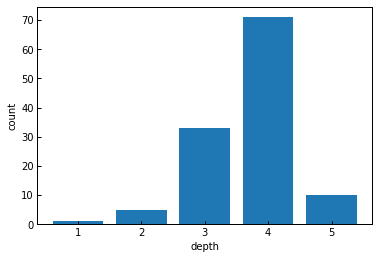

In [7]:
Seed = Analyze_Seed(3, 6)
AH = Analyze_Hitblow(Seed, 5)

tree_list, params = AH.analyze_earnest_tree()

print(params)
PH = Practice_Hitblow(Seed, tree_list)
PH.export_as_graph("tree")
depth_list = PH.count_by_depth()

plt.xlabel("depth")
plt.ylabel("count")
plt.bar(np.arange(1, len(depth_list)), depth_list[1:])

## 解析結果

以下の解析結果について示す。

1. n桁×m種の場合について必要最小手数の変化を調べた。
2. 3桁×10種、4桁×6種の場合についてそれぞれ最小期待値手数となる手順を求めた。

### n桁×m種の場合による必要最小手数の変化

In [12]:
depth_list = [[-1]*11 for _ in range(7)]
elapsed_time_list = [[-1]*11 for _ in range(7)]
for i in range(2, 7):
    for j in range(i, 11):
        
        Seed = Analyze_Seed(i, j)
        AH = Analyze_Hitblow(Seed, 600)
        if AH.Seed.pat_length > 720: break
        start_time = time.time()
        tree_list, params = AH.analyze_fastest_tree()
        elapsed_time = time.time()-start_time

        
        depth_list[i][j] = params["max_depth"]
        elapsed_time_list[i][j] = elapsed_time

        print(i, j, "max_depth =", params["max_depth"])
        print("elapsed time =", elapsed_time, "s")
        print()

print("-"*30)
print()
print(depth_list)

initialize completed
analyze completed
params setted
2 2 max_depth = 2
elapsed time = 9.34600830078125e-05 s

initialize completed
analyze completed
params setted
2 3 max_depth = 3
elapsed time = 0.00016617774963378906 s

initialize completed
analyze completed
params setted
2 4 max_depth = 3
elapsed time = 0.0003523826599121094 s

initialize completed
analyze completed
params setted
2 5 max_depth = 4
elapsed time = 0.011735677719116211 s

initialize completed
analyze completed
params setted
2 6 max_depth = 4
elapsed time = 0.008878469467163086 s

initialize completed
analyze completed
params setted
2 7 max_depth = 5
elapsed time = 0.16113758087158203 s

initialize completed
analyze completed
params setted
2 8 max_depth = 5
elapsed time = 0.8853223323822021 s

initialize completed
analyze completed
params setted
2 9 max_depth = 6
elapsed time = 1.9809257984161377 s

initialize completed
analyze completed
params setted
2 10 max_depth = 6
elapsed time = 5.269698143005371 s

initialize com

KeyboardInterrupt: ignored

findfont: Font family ['Yu Mincho'] not found. Falling back to DejaVu Sans.


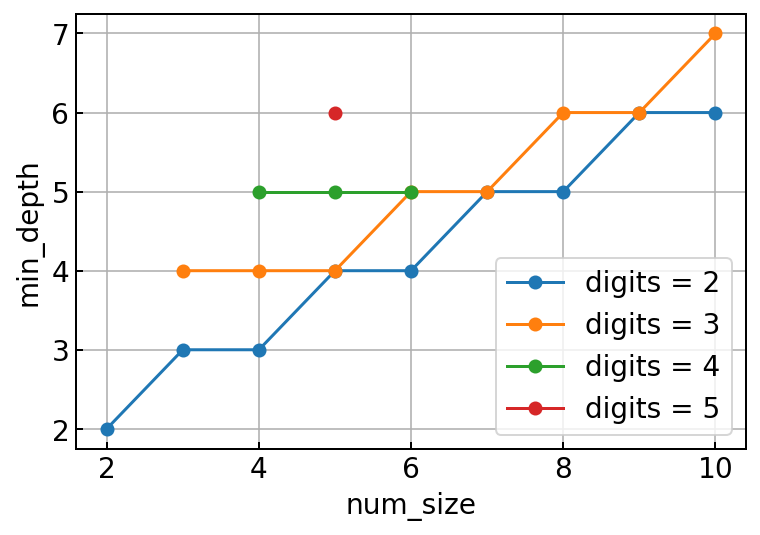

In [13]:
for i in range(2, 6):
    data = np.array(depth_list[i])
    x = np.arange(11, dtype=object)
    x[data == -1] = None
    #print(x, data)
    plt.plot(x, data, "-o", label="digits = {0}".format(i))

plt.xlabel("num_size")
plt.ylabel("min_depth")
plt.grid()
plt.legend()

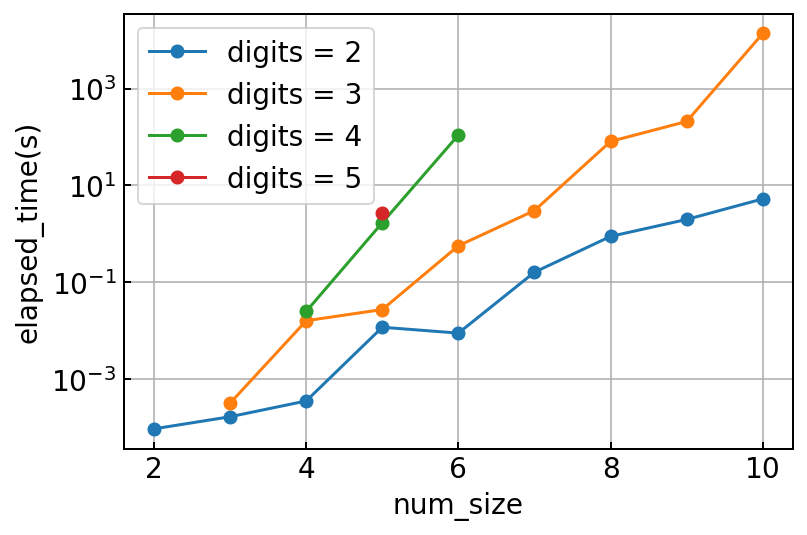

In [14]:
for i in range(2, 6):
    data = np.array(elapsed_time_list[i])
    x = np.arange(11, dtype=object)
    x[data == -1] = None
    #print(x, data)
    plt.plot(x, data, "-o", label="digits = {0}".format(i))

plt.yscale("log")
plt.xlabel("num_size")
plt.ylabel("elapsed_time(s)")
plt.grid()
plt.legend()

### 最小期待値手数

#### 3桁×10種のHitBlow

In [ ]:
n, m = 3, 10
Seed = Analyze_Seed(n, m)
AH = Analyze_Hitblow(Seed, 1800)

tree_list, params = AH.analyze_earnest_tree()

params

initialize completed


In [ ]:
DH = Practice_Hitblow(Seed, tree_list)
DH.export_as_graph("3_10_earnest_tree")

#### 4桁×6種のHitBlow

In [ ]:
n, m = 4, 6

Seed = Analyze_Seed(n, m)
AH = Analyze_Hitblow(Seed, 60)

tree_list, params = AH.analyze_earnest_tree()

params

initialize completed
elapsed time = 60.0 s
loop_count = 55041
registed count = 130

elapsed time = 120.0 s
loop_count = 106167
registed count = 256

elapsed time = 180.0 s
loop_count = 165344
registed count = 275

elapsed time = 240.0 s
loop_count = 216670
registed count = 359

elapsed time = 300.0 s
loop_count = 273928
registed count = 359

analyze completed
params setted


{'depth_mean': 4.086111111111111,
 'depth_sum': 1471,
 'max_depth': 5,
 'node_num': 360}

In [ ]:
DH = Practice_Hitblow(Seed, tree_list)
DH.export_as_graph("4_6_earnest_tree", list(range(1, 7)))

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.959277 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.959277 to fit


### 主要なHitBlowの結果パラメータ

find_earnest_treeの解析によって得られたパラメータを示す。

- 4桁×6種: 
{'max_depth': 5, 'depth_sum': 1471, 'node_num': 360, 'depth_mean': 4.086111111111111}

- 3桁×9種: 
{'max_depth': 6, 'depth_sum': 2368, 'node_num': 504, 'depth_mean': 4.698412698412699}

- 3桁×10種: 
{'max_depth': 7, 'depth_sum': 3611, 'node_num': 720, 'depth_mean': 5.0152777777777775}
